<a href="https://colab.research.google.com/github/metahwi/MachineLearning/blob/main/Breast%20Cancer%20Classification%20SVM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Linear Support Vector Machines


## Breast Cancer Classification

This notebook will study another very useful application of machine learning in health care. We will be using the [Breat Cancer Wisconsin (Diagnostic) dataset](https://archive.ics.uci.edu/dataset/17/breast+cancer+wisconsin+diagnostic) which has collections of digitized images of breast masses and labels as whether the mass had been diagnosed with malign tumors. The dataset is available on the sklearn library, and we can load it as follows.

In [ ]:
from sklearn.datasets import load_breast_cancer
import pandas as pd

cancer_dataset = load_breast_cancer() # Load the data and convert to a pandas dataframe
df = pd.DataFrame(cancer_dataset.data, columns=cancer_dataset.feature_names)
df['target'] = pd.Series(cancer_dataset.target)

print(df.head()) # Print out the first five data points.

   mean radius  mean texture  mean perimeter  mean area  mean smoothness  \
0        17.99         10.38          122.80     1001.0          0.11840   
1        20.57         17.77          132.90     1326.0          0.08474   
2        19.69         21.25          130.00     1203.0          0.10960   
3        11.42         20.38           77.58      386.1          0.14250   
4        20.29         14.34          135.10     1297.0          0.10030   

   mean compactness  mean concavity  mean concave points  mean symmetry  \
0           0.27760          0.3001              0.14710         0.2419   
1           0.07864          0.0869              0.07017         0.1812   
2           0.15990          0.1974              0.12790         0.2069   
3           0.28390          0.2414              0.10520         0.2597   
4           0.13280          0.1980              0.10430         0.1809   

   mean fractal dimension  ...  worst texture  worst perimeter  worst area  \
0             

Let's gather a few summary statistics about our data.

N = 569 data points


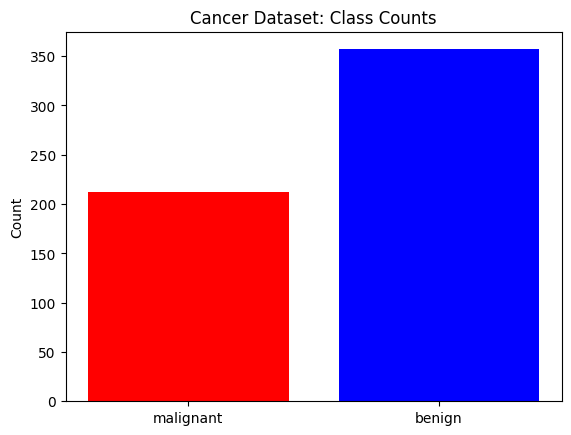

In [ ]:
import matplotlib.pyplot as plt

N = len(df) # The number of data points.
print('N = {:d} data points'.format(N))

# Give a barplot of each class.
plt.figure()
plt.bar([0,1], df['target'].value_counts(ascending = True), color = ['r', 'b'], tick_label = cancer_dataset.target_names)
plt.ylabel('Count')
plt.title('Cancer Dataset: Class Counts');

We can now prepare to use the dataset for building our classification model. We split it into training and validation set using the Scikit-learn functions.

In [ ]:
from sklearn import model_selection

x = cancer_dataset.data   # The features.
y = cancer_dataset.target # The targets.

# Print the dataset sizes.
print('Shape of X = ', x.shape)
print('Shape of y = ', y.shape)

# Split the data into a training and test set.
x_train, x_val, y_train, y_val = model_selection.train_test_split(x, y, test_size = 0.33, random_state=7)

Shape of X =  (569, 30)
Shape of y =  (569,)


Using the data sets we prepared, we will train a linear SVM using Scikit-learn. We can also build a logistic regression model using Scikit-learn to compare the performance of each algorithm.

In [ ]:
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

# Train the linear SVM.

svm = LinearSVC(dual = False) # Uses the squared-hinge loss function when fitting the model.
svm.fit(x_train, y_train)

# Now evaluate it on the test points.
y_pred = svm.predict(x_val)

acc = metrics.accuracy_score(y_val, y_pred)
print('Linear SVM validation accuracy = {:0.1f}%'.format(100*acc))

# Compare to a simple logistic regression model.

lr = LogisticRegression(solver = 'liblinear')
lr.fit(x_train, y_train)
y_pred = lr.predict(x_val)

acc = metrics.accuracy_score(y_val, y_pred)
print('Logistic Regression validation accuracy = {:0.1f}%'.format(100*acc))

Linear SVM validation accuracy = 95.7%
Logistic Regression validation accuracy = 95.2%


As we can see, a basic linear SVM already does very well and is comparable to logistic regression.

Let's compare logistic regression with SVM for binary classification.  Suppose that our data has $n$ features and we have trained a logistic regression model with weight vector $\theta_{\mathrm{LR}}\in \mathbb{R}^{n+1}$ as well as a linear SVM with parameters $w_{\mathrm{SVM}}\in \mathbb{R}^n$, and $b_{\mathrm{SVM}}\in \mathbb{R}$.  Assume that the optimal parameters have been found in both cases.  If the data is linearly separable then is it true that $\theta_{\mathrm{LR}} = (b_{\mathrm{SVM}}, w_{\mathrm{SVM}})$?

If not then why?

**They will not be the same in general.**

Even though we optimize SVM parameters like logistic regression (with gradient descent), SVM has the _hinge loss_:

$$
\sum_{i=1}^n max[1 - y_i(w^Tx + b), 0]
$$

while logistic regression has the _logistic loss_.

Consider the dataset $X = (-5, -1, 1, 2)^T$ and $y = (-1, -1, 1, 1)^T$ (equivalently $y = (0,0,1,1)^T$ for logistic regression).  The SVM parameters will just be $(b_{\mathrm{SVM}}, w_{\mathrm{SVM}}) = (0,1)$.  However, the logistic regression parameters will be slightly different.  Recall the gradient of the loss function for logistic regression is
$$
\nabla_{\theta}J(\theta) = -\sum_{i=1}^4 (y_i - h(X_i;\theta))X_i
$$

where
$$
h(x;\theta) = \frac{1}{1 + \exp(-\theta^Tx)}
$$
However, if we plug all of the values into the gradient we get
$$
\nabla_{\theta}J((b_{\mathrm{SVM}}, w_{\mathrm{SVM}})) = -\left( \frac{5}{1+e^{5}} + \frac{1}{1+e^{1}} + \frac{e^{-1}}{1+e^{-1}} +  \frac{2e^{-2}}{1 + e^{-2}} \right) \neq 0
$$
Since the gradient is non-zero we know that $(b_{\mathrm{SVM}}, w_{\mathrm{SVM}})$ is not the optimal value for the logistic regression loss function and hence cannot be $\theta_{\mathrm{LR}}$.

### Case of non-linearly separable dataset

If the data is linear separable, then a linear SVM should be able to achieve 100% accuracy.  However, this is rarely the case since even the breast cancer dataset was not exactly linear separable.  We'll use a fake dataset to illustrate this.  This data is drawn from a bi-modal Gaussian mixture model.

In [ ]:
"""
Input:
    N : the number of data points

Output:
    X, y : the features and targets of shapes (N,2) and (N, )
"""

import numpy as np

def sample_bimodal_data(N):

    # The two modes and covariances.
    mu1 = np.asarray([-1, 0])
    mu2 = np.asarray([1, 0])

    cov1 = 2 * np.identity(2)
    cov2 = 2 * np.identity(2)

    N1 = N//2   # Number of points in first class.
    N2 = N - N1 # Number of points in second class.

    # Sample the random points.
    X1 = np.random.multivariate_normal(mu1, cov1, N1)
    X2 = np.random.multivariate_normal(mu2, cov2, N2)
    Y1 = np.zeros(N1)
    Y2 = np.ones(N2)

    # Combine the data.
    X = np.vstack((X1, X2))
    Y = np.concatenate((Y1, Y2), axis = None)

    return X,Y

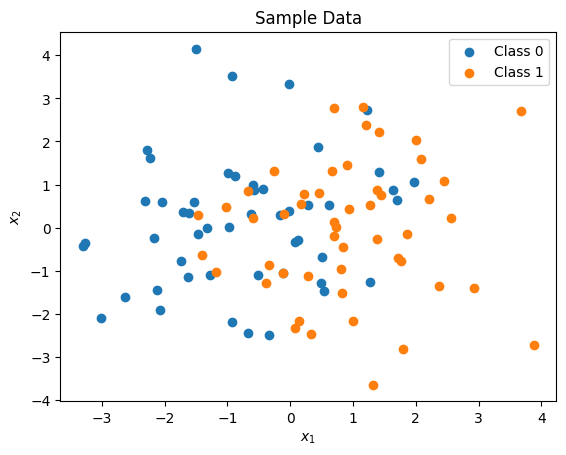

In [ ]:
# Plot the sample data.
N = 100
X,Y = sample_bimodal_data(N)

plt.figure(1)
plt.scatter(X[:N//2, 0], X[:N//2, 1], label = 'Class 0')
plt.scatter(X[N - N//2:, 0], X[N - N//2:, 1], label = 'Class 1')
plt.legend()
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')
plt.title('Sample Data');

Increasing the factor in front of the covariances or shifting the centers of the two distributions to be closer to each other will cause the data to overlap more, making it harder to classify. Lets see how that would look like.

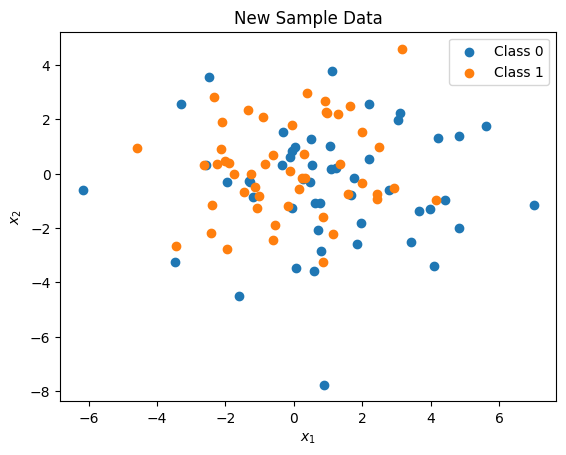

In [ ]:
# Change the sample bi_modal_data function such that
# the two multivariate distributions have similar means,
# create a plot with the samples from the two distributions

def sample_bimodal_data(N):

    # The two modes and covariances.
    mu1 = np.asarray([1, 0])
    mu2 = np.asarray([-1, 0])

    cov1 = 5 * np.identity(2)
    cov2 = 5 * np.identity(2)

    N1 = N//2   # Number of points in first class.
    N2 = N - N1 # Number of points in second class.

    # Sample the random points.
    X1 = np.random.multivariate_normal(mu1, cov1, N1)
    X2 = np.random.multivariate_normal(mu2, cov2, N2)
    Y1 = np.zeros(N1)
    Y2 = np.ones(N2)

    # Combine the data.
    X = np.vstack((X1, X2))
    Y = np.concatenate((Y1, Y2), axis = None)

    return X,Y

# Plot the sample data.
N = 100
X,Y = sample_bimodal_data(N)

plt.figure(1)
plt.scatter(X[:N//2, 0], X[:N//2, 1], label = 'Class 0')
plt.scatter(X[N - N//2:, 0], X[N - N//2:, 1], label = 'Class 1')
plt.legend()
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')
plt.title('New Sample Data');

#### Using a slack variable C

Since the data is not perfectly linearly separable you'll want to use a slack variable which allows SVM to handle this dataset.  Let's train some models with different values of $C$ and compare them using cross-validation.

In [ ]:
# First get the data and split it into training and testing.

N = 100
X, Y = sample_bimodal_data(N)

# Use a 70/30 split
X_train, X_val, Y_train, Y_val = model_selection.train_test_split(X, Y, test_size = 0.30, random_state = 981)

SVM accuracy = 80.0%


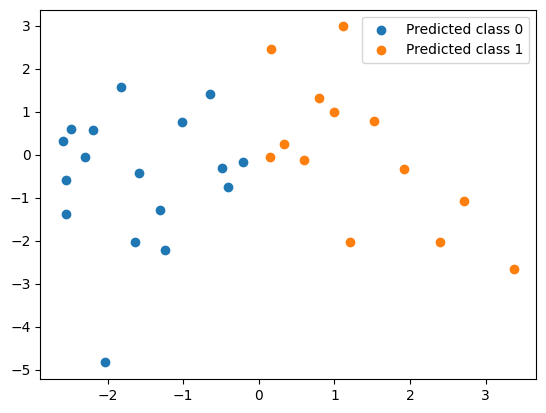

In [ ]:
# Define the SVM model to use with a slack variable
svm = LinearSVC(C = 1e-10, dual = False)
svm.fit(X_train, Y_train)
svmpred = svm.predict(X_val)
acc = metrics.accuracy_score(Y_val, svmpred)
print('SVM accuracy = {:0.1f}%'.format(100*acc))

plt.figure(2)
I = svmpred == 0
plt.scatter(X_val[I, 0], X_val[I, 1], label = 'Predicted class 0')
I = svmpred == 1
plt.scatter(X_val[I, 0], X_val[I, 1], label = 'Predicted class 1')
plt.legend()
plt.show()

Using the provided example, experiment with various different mu1 values and demonstrate SVM accuracy gets worse as mu1 and mu2 get closer.

In [ ]:

from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

N = 100
X, Y = sample_bimodal_data(N)

# Use a 70/30 split
X_train, X_val, Y_train, Y_val = model_selection.train_test_split(X, Y, test_size = 0.30, random_state = 981)

# Train the linear SVM.

svm = LinearSVC(dual = False) # Uses the squared-hinge loss function when fitting the model.
svm.fit(x_train, y_train)

# Now evaluate it on the test points.
y_pred = svm.predict(x_val)

acc = metrics.accuracy_score(y_val, y_pred)
print('New Linear SVM validation accuracy = {:0.1f}%'.format(100*acc))

# Compare to a simple logistic regression model.

lr = LogisticRegression(solver = 'liblinear')
lr.fit(x_train, y_train)
y_pred = lr.predict(x_val)

acc = metrics.accuracy_score(y_val, y_pred)
print('New Logistic Regression validation accuracy = {:0.1f}%'.format(100*acc))

New Linear SVM validation accuracy = 95.7%
New Logistic Regression validation accuracy = 95.2%


Let's train some models with different $C$ and compare them use cross-validation.

In [ ]:
# Define the different SVM models to use
from sklearn import model_selection

svm_1 = LinearSVC(C = 10, dual = False)
svm_2 = LinearSVC(C = 1, dual = False)
svm_3 = LinearSVC(C = 1e-3, dual = False)
svm_4 = LinearSVC(C = 1e-7, dual = False)

split = model_selection.KFold(5)
# Get the CV scores.
cv_1 = model_selection.cross_val_score(svm_1, X_train, Y_train, cv = split)
cv_2 = model_selection.cross_val_score(svm_2, X_train, Y_train, cv = split)
cv_3 = model_selection.cross_val_score(svm_3, X_train, Y_train, cv = split)
cv_4 = model_selection.cross_val_score(svm_4, X_train, Y_train, cv = split)

# Print the average scores.
print('C = 10    CV average score = {:0.1f}%'.format(np.mean(cv_1) * 100))
print('C = 1     CV average score = {:0.1f}%'.format(np.mean(cv_2) * 100))
print('C = 1e-3  CV average score = {:0.1f}%'.format(np.mean(cv_3) * 100))
print('C = 1e-7  CV average score = {:0.1f}%'.format(np.mean(cv_4) * 100))

C = 10    CV average score = 72.9%
C = 1     CV average score = 72.9%
C = 1e-3  CV average score = 72.9%
C = 1e-7  CV average score = 74.3%


We see that the model performs slightly differently for different values of the slack variable $C$.  

$$
\min_{w,b,\zeta} \frac{1}{2}w^Tw + C\sum_{i=1}^n \zeta_i,\quad \text{ such that }\quad y_i(w^Tx_i + b) \ge 1 - \zeta_i,\quad \zeta_i \ge 0
$$

See the sci-kit [documentation](https://scikit-learn.org/stable/modules/svm.html) for more details.  We can also plot a curve of the validation score for many different $C$ values which can be helpful for determining the optimal hyperparameter.

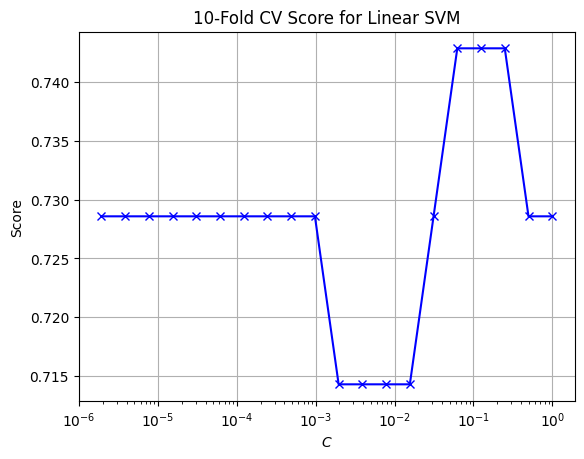

In [ ]:
# Get the C values we want to look at.
C = 1/(2**np.arange(0, 20)) # 1,...,1e-6

k = 10 # Kfold CV.
cv_scores = np.zeros(len(C))
split = model_selection.KFold(k)
for i in range(len(C)):
    svm = LinearSVC(C = C[i], dual = False)
    cv_scores[i] = np.mean(model_selection.cross_val_score(svm, X_train, Y_train, cv = split))

plt.figure(2)
plt.semilogx(C, cv_scores, 'b-x')
plt.xlabel(r'$C$')
plt.ylabel(r'Score')
plt.title(r'{:d}-Fold CV Score for Linear SVM'.format(k))
plt.grid();

We can use this plot to find the optimal value of the slack variables based on the cross validation score. Now let's see how our 4 models from earlier actually do on the validation set.

In [ ]:
# Define the different SVM models to use
svm_1 = LinearSVC(C = 10, dual = False)
svm_2 = LinearSVC(C = 1, dual = False)
svm_3 = LinearSVC(C = 1e-3, dual = False)
svm_4 = LinearSVC(C = 1e-7, dual = False)

# Fit the models.
svm_1.fit(X_train, Y_train)
svm_2.fit(X_train, Y_train)
svm_3.fit(X_train, Y_train)
svm_4.fit(X_train, Y_train)

# Make the predictions.
pred1 = svm_1.predict(X_val)
pred2 = svm_2.predict(X_val)
pred3 = svm_3.predict(X_val)
pred4 = svm_4.predict(X_val)

# Evaluate the models.
acc1 = metrics.accuracy_score(Y_val, pred1)
acc2 = metrics.accuracy_score(Y_val, pred2)
acc3 = metrics.accuracy_score(Y_val, pred3)
acc4 = metrics.accuracy_score(Y_val, pred4)

print('Linear SVM (C = 10)   accuracy = {:0.1f}%'.format(100*acc1))
print('Linear SVM (C = 1)    accuracy = {:0.1f}%'.format(100*acc2))
print('Linear SVM (C = 1e-3) accuracy = {:0.1f}%'.format(100*acc3))
print('Linear SVM (C = 1e-7) accuracy = {:0.1f}%'.format(100*acc4))

Linear SVM (C = 10)   accuracy = 80.0%
Linear SVM (C = 1)    accuracy = 80.0%
Linear SVM (C = 1e-3) accuracy = 80.0%
Linear SVM (C = 1e-7) accuracy = 80.0%


### More examples of non-linearly separable datasets

In [ ]:
"""
Input:
    N : the number of data points

Output:
    X, y : the features and targets of shapes (N,2) and (N, )
"""
def gen_data1(N):
    N1 = N//2
    N2 = N - N1
    t = np.linspace(0, 2*np.pi, N1)

    X1 = np.zeros((N1, 2))
    X1[:,0] = 4*np.cos(t) + 0.1*np.random.randn(N1)
    X1[:,1] = 4*np.sin(t) + 0.1*np.random.randn(N1)
    y1 = np.zeros(N1)

    X2 = np.random.randn(2*N2)
    X2 = X2.reshape((N2, 2))
    y2 = np.ones(N2)

    # Combine the data.
    X = np.vstack((X1, X2))
    y = np.concatenate((y1, y2), axis = None) # axis = None means that arrays flattened before use

    return X,y

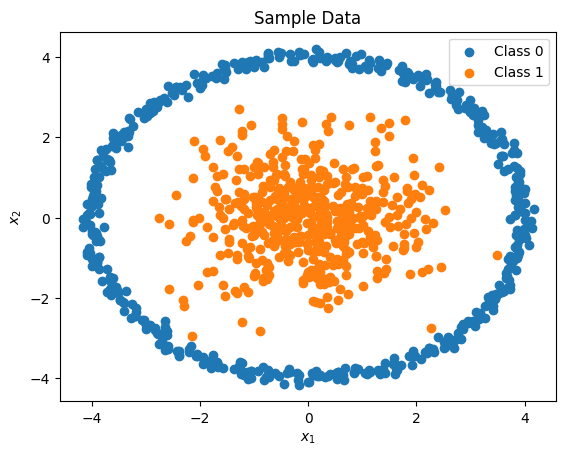

In [ ]:
# Plot the data.
N = 1000
X, Y = gen_data1(N)

plt.figure(3)
plt.scatter(X[:N//2, 0], X[:N//2, 1], label = 'Class 0')
plt.scatter(X[N - N//2:, 0], X[N - N//2:, 1], label = 'Class 1')
plt.legend()
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')
plt.title('Sample Data');

SVM accuracy = 37.7%


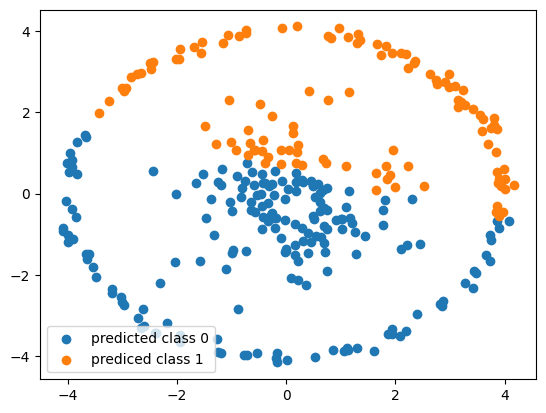

In [ ]:
# Define the different SVM models to use
# Use a 70/30 split
X_train, X_val, Y_train, Y_val = model_selection.train_test_split(X, Y, test_size = 0.3, random_state = 981)
svm = LinearSVC(C = 1e+10, dual = False)
svm.fit(X_train, Y_train)
svmpred = svm.predict(X_val)
acc = metrics.accuracy_score(Y_val, svmpred)
print('SVM accuracy = {:0.1f}%'.format(100*acc))

plt.figure(2)
I = svmpred == 0
plt.scatter(X_val[I, 0], X_val[I, 1], label = 'predicted class 0')
I = svmpred == 1
plt.scatter(X_val[I, 0], X_val[I, 1], label = 'prediced class 1')
plt.legend()
plt.show()

Here the data is not linearly separable although we can very clearly see some separation. If we transform the data by only looking at the radius, then we would be able to linearly separate the data.

(1000, 2)


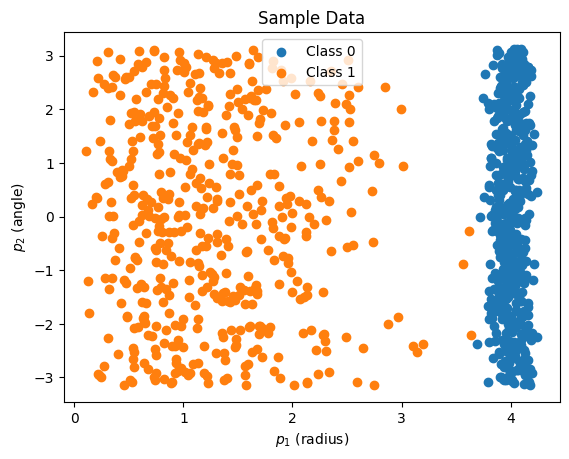

In [ ]:
def cart2pol(x, y):
    rho = np.sqrt(x**2 + y**2)
    phi = np.arctan2(y, x)
    return (rho, phi)

pX = np.vstack(cart2pol(X[:, 0], X[:, 1])).T
print(pX.shape)
plt.figure(4)
plt.scatter(pX[:N//2, 0], pX[:N//2, 1], label = 'Class 0')
plt.scatter(pX[N - N//2:, 0], pX[N - N//2:, 1], label = 'Class 1')
plt.legend()
plt.xlabel(r'$p_1$ (radius)')
plt.ylabel(r'$p_2$ (angle)')
plt.title('Sample Data');

In [ ]:
# Define the different SVM models to use
# Use a 70/30 split
X_train, X_val, Y_train, Y_val = model_selection.train_test_split(pX, Y, test_size = 0.3, random_state = 981)
svm = LinearSVC(C = 1e+10, dual = False)
svm.fit(X_train, Y_train)
svmpred = svm.predict(X_val)
acc = metrics.accuracy_score(Y_val, svmpred)
print('SVM accuracy = {:0.1f}%'.format(100*acc))

SVM accuracy = 100.0%
